# SPML HW3 - Universal Adversarial Perturbation (30)


**Initial Setups** 

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from typing import Type
import numpy as np

# Please use CUDA

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
if device == 'cuda':
  print(torch.cuda.get_device_name(0))





cuda
Quadro RTX 6000


**Installing & Importing torchattacks for deepfool**

In [8]:
"""
Deepfool attack is used in UAP algorithm
We suggest to use torchattacks library and its implemented DeepFool
"""

!pip install git+https://github.com/Harry24k/adversarial-attacks-pytorch.git


  Cloning https://github.com/Harry24k/adversarial-attacks-pytorch.git to /tmp/pip-req-build-28haad8o
  Running command git clone --filter=blob:none --quiet https://github.com/Harry24k/adversarial-attacks-pytorch.git /tmp/pip-req-build-28haad8o
  Resolved https://github.com/Harry24k/adversarial-attacks-pytorch.git to commit c4da6a95546283992a3d1816ae76a0cd4dfc2d8b
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 419.9 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 1.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.8 MB/s eta 0:00:00
  Created wheel for torchattacks: filename=torchattacks-3.4.1-py3-none-any.whl size=136361 sha256=96e0cbed7d4879a6006d06432f69a18c5ee40509b9a5f7c65e6b1aa23745fc6a
  Stored in directory: /tmp/pip-ephem-wheel-cache-zr_38qkm/wheels/9a/7f/d4/443428e9096ecec86c1b3a819ae8877fdec6d52ff661f49b85
Successfully built torchattacks
  Attempting

In [6]:
import torchattacks



**[1] Projection function**

In [7]:
#In this function you wil implement projection due to the given norm (p) 
#For now, only p = 2 and p = Inf is needed to be supported by your function
#Project on the lp ball centered at 0 and of radius e

def proj_lp(v, e, p):
    if p == 2:
        norm = torch.linalg.vector_norm(v, dim=1, keepdim=True)
        if norm > e:
            v = v / norm * e
    elif p == np.inf:
        v = v.clamp(min=-e, max=e)
    else:
        raise ValueError('Values of p different from 2 and Inf are currently not supported!')
    return v

**[2] UAP generation**

In [8]:
torchattacks.DeepFool?

In [9]:
#In this function you will implement UAP algorithm for generating a universal perturbation based on the given dataset and model

def universal_pert(dataset, model, delta=0.1, max_iter_uni = np.inf, eps=10, p=np.inf, num_classes=10, df_overshoot=0.02, df_steps=10):
    '''
    :param dataset: Pytorch Dataset
    :param model: Model to be fooled by the adversarial examples
    :param delta: 1-delta represents the fooling_rate, and the objective (default = 90% fooling rate)
    :param max_iter_uni: Maximum number of iterations of the main algorithm
    :param eps: Controls the l_p magnitude of the perturbation (default = 10)
    :param p: Only p==2 or p==infinity are supported
    :param num_classes: Number of classes on the dataset
    :param df_overshoot: Parameter to the Deep_fool algorithm
    :param df_steps: Maximum iterations of the deep fool algorithm
    :return: perturbation found (and also fooling_rates for iterations and number of total_iterations)
    '''

    model.eval()
    deepfool = torchattacks.DeepFool(model, steps=df_steps, overshoot=df_overshoot)

    # Initializing the perturbation to 0s
    input_image_example = dataset[0][0]
    v = torch.zeros_like(input_image_example, requires_grad=False).to(device) # your code goes here
    # ic(torch_shape_get(input_image_example), v.shape)

    #Initializing fooling rate and iteration count
    fooling_rate = 0.0
    iter = 0

    fooling_rates=[]
    total_iterations = []

    """
    Begin of the main loop on Universal Adversarial Perturbations algorithm
    (Provide the conditions due to given delta and maximum number of iterations)
    """
    while (fooling_rate < 1.0 - delta) and (iter < max_iter_uni): #: your code goes here:
      print ('Starting pass number ', iter)

      # Go through the trainset and compute the perturbation increments sequentially
      for i, data in enumerate(dataset):
        image, label = data
        #: label is a single int
        # ic(label)
        label_pt = torch.tensor(label).reshape(1, 1)
        # ic(label, label_pt)

        image = image.reshape([1,3,32,32]).to(device)

        with torch.no_grad():
            image_pert = image + v
            output = model(image_pert)

        if output.argmax(dim=1) == label: #your code goes here:
                print('>> k = ', i, ', iter #', iter)

                # Finding a new minimal perturbation with deepfool to fool the network on this image
                pert = deepfool(image, label_pt)
                # ic(pert.shape)
                #: pert.shape: torch.Size([1, 3, 32, 32])

                #Update v appropriately
                v = v + (pert - image)
                v = proj_lp(v, eps, p)


      iter = iter + 1

      with torch.no_grad():
        batch_size = 128
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False) #your code goes here

        total = 0
        fooled = 0

        """Calculate fooling rate
        (Go through the dataset and check that v can fool the model or not. Calculate the ratio of fooled samples to total number of samples.)
        """
        for i, data in enumerate(dataloader):
            image, label = data
            image, label = image.to(device), label.to(device)
            image_pert = image + v

            total += image.size(0)
            fooled += (model(image_pert).argmax(dim=1) != label).sum().item()

        fooling_rate = fooled / total

        torch.cuda.empty_cache()

        print("FOOLING RATE: ", fooling_rate)
        fooling_rates.append(fooling_rate)
        total_iterations.append(iter)



    return v,fooling_rates,total_iterations




**Loading CIFAR10**

In [10]:
batch_size = 128
transform = transforms.Compose([transforms.ToTensor(),])

cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train = True, download = True, transform = transform)
cifar_trainloader = torch.utils.data.DataLoader(cifar_trainset, batch_size = batch_size, shuffle = True, num_workers = 2)

cifar_testset = torchvision.datasets.CIFAR10(root='./data', train = False, download = True, transform = transform)
cifar_testloader = torch.utils.data.DataLoader(cifar_testset, batch_size = batch_size, shuffle = False, num_workers = 2)


Files already downloaded and verified
Files already downloaded and verified


**[3]Loading model**

In [11]:
'''ResNet in PyTorch.
For Pre-activation ResNet, see 'preact_resnet.py'.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])

def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

In [12]:
model = ResNet18()
model = model.to(device)
model.train()

learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [13]:
#Load model state dict using the given saved model in './SPML_HW4_UAP_resnet18_cifar10_model_std' (The model is trained with CIFAR10 trainset)
#your code goes here

saved_model_path = './SPML_HW4_UAP_resnet18_cifar10_model_std'
checkpoint = torch.load(saved_model_path, map_location=device)
# torch_shape_get(checkpoint)

model.load_state_dict(checkpoint)

<All keys matched successfully>

**Generate universal perturbation for CIFAR10 using your function**

In [14]:
#First, split the cifar testset into two distinct dataset (Note that number of samples from each class is balanced in these two dataset.)
#UAP_dataset: 50% of testset for using in your UAP algorithm
#evaluation_dataset: 50% of testset for final evaluation of UAP function (Calculating fooling rates of universal v over unseen cifar test samples)
#Then, use your UAP function for generating universal perturbation
from sklearn.model_selection import train_test_split


UAP_dataset, evaluation_dataset = train_test_split(cifar_testset, test_size=0.5, stratify=cifar_testset.targets)

v, fooling_rates, total_iterations = universal_pert(UAP_dataset, model)

Starting pass number  0
>> k =  0 , iter # 0
>> k =  1 , iter # 0
>> k =  2 , iter # 0
>> k =  4 , iter # 0
>> k =  5 , iter # 0
>> k =  6 , iter # 0
>> k =  8 , iter # 0
>> k =  10 , iter # 0
>> k =  11 , iter # 0
>> k =  14 , iter # 0
>> k =  16 , iter # 0
>> k =  17 , iter # 0
>> k =  19 , iter # 0
>> k =  21 , iter # 0
>> k =  22 , iter # 0
>> k =  23 , iter # 0
>> k =  24 , iter # 0
>> k =  25 , iter # 0
>> k =  27 , iter # 0
>> k =  28 , iter # 0
>> k =  29 , iter # 0
>> k =  30 , iter # 0
>> k =  31 , iter # 0
>> k =  35 , iter # 0
>> k =  37 , iter # 0
>> k =  38 , iter # 0
>> k =  40 , iter # 0
>> k =  41 , iter # 0
>> k =  42 , iter # 0
>> k =  43 , iter # 0
>> k =  44 , iter # 0
>> k =  45 , iter # 0
>> k =  46 , iter # 0
>> k =  47 , iter # 0
>> k =  48 , iter # 0
>> k =  49 , iter # 0
>> k =  50 , iter # 0
>> k =  51 , iter # 0
>> k =  52 , iter # 0
>> k =  53 , iter # 0
>> k =  54 , iter # 0
>> k =  55 , iter # 0
>> k =  56 , iter # 0
>> k =  57 , iter # 0
>> k =  59 , it

**[4] Plot fooling rates over iterations in UAP**



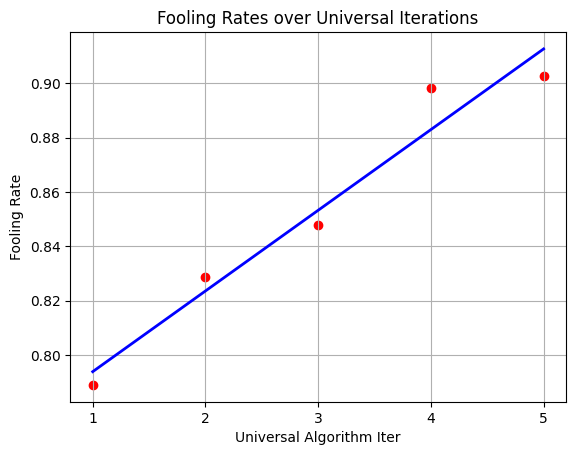

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from matplotlib.ticker import MaxNLocator

plt.title("Fooling Rates over Universal Iterations")
plt.xlabel("Universal Algorithm Iter")
plt.ylabel("Fooling Rate")


slope, intercept, r_value, p_value, std_err = stats.linregress(total_iterations, fooling_rates)
line = slope*np.array(total_iterations)+intercept

plt.scatter(total_iterations, fooling_rates, color='red')
plt.plot(total_iterations, line, color='blue', linewidth=2)

ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.grid(True)
plt.show()


**[6] Evaluate fooling rate of universal v on testset**

In [18]:
def get_fooling_rate(model, dataloader, v,):
    total = 0
    fooled = 0
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            image, label = data
            image, label = image.to(device), label.to(device)
            image_pert = image + v

            total += image.size(0)
            fooled += (model(image_pert).argmax(dim=1) != label).sum().item()

        fooling_rate = fooled / total

        torch.cuda.empty_cache()

    return fooling_rate

In [19]:
#In this section, you will calculate the ratio of fooled samples to total number of samples over unseen test samples

#check the robustness of model on perturbed test samples with your universal perturbation (output of your algorithm on previous sections)

evaluation_dataloader = torch.utils.data.DataLoader(evaluation_dataset, batch_size=256, shuffle=False)
evaluation_fooling_rate = get_fooling_rate(model=model, dataloader=evaluation_dataloader, v=v,)
print(evaluation_fooling_rate)



0.8954


In [20]:

evaluation2_dataloader = torch.utils.data.DataLoader(UAP_dataset, batch_size=256, shuffle=False)
evaluation2_fooling_rate = get_fooling_rate(model=model, dataloader=evaluation2_dataloader, v=v,)
print(evaluation2_fooling_rate)


0.9026
